<a href="https://colab.research.google.com/github/FilipposMoscholios/Text-Analytics/blob/main/Code_TA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Text Analytics Exercise 2

Develop a **sentiment classifier** for a kind of texts of your choice (e.g., tweets, product or
**movie reviews**). Use an existing sentiment analysis dataset with at least **two classes** (e.g.,
**positive/negative** or positive/negative/neutral).
The classes should be **mutually exclusive**, i.e.,
this is a single-label multi-class classification problem. You may use Boolean, TF, or **TF-IDF**
features corresponding to words or n-grams, to which you can also add other features (e.g.,
lexicon features). You may apply any feature selection (or **dimensionality reduction**) method
you consider appropriate. You may also want to try using centroids of pre-trained word
embeddings. You can write your own code to produce feature vectors, perform feature
selection (or dimensionality reduction) and train the classifier (e.g., using SGD, in the case of
logistic regression), or you can use existing implementa4
tions and software libraries. You should experiment with **at least logistic regression** (or multinomial logistic regression, if you
have more than two classes) and optionally (if you are keen and have free time) additional
learning algorithms (e.g., **Naive Bayes, k-NN**). Assume that each text is classified in the class
the classifier considers most probable. Make sure that you **use separate training, development, and test subsets** . **Tune the feature set and hyper-parameters** (e.g., regularization weight λ in
logistic regression) **on the development** subset. Include experimental results of a **baseline majority classifier**, i.e., a classifier that always assigns the most frequent class of the training data. Include in your report:

*  Precision, recall, F1, precision-recall AUC scores, for each class and classifier, separately for the training, development, and test subsets. Use three separate tables for the training, development, and test results. In each table, use a separate row for each classifier (or baseline), and show the precision, recall, F1, PR-AUC scores of the classes in columns (four columns per class).


*  Macro-averaged precision, recall, F1, precision-recall AUC scores (all computed by averaging the corresponding scores of the previous bullet over the classes), for each classifier, separately for the training, development, and test subsets. Show these results by adding four more columns to the tables of the previous bullet.


*  For each classifier, learning curves (slides 59, 62) showing macro-averaged F1 computed on (i) the training data the classifier has encountered, (ii) the entire development subset, (iii) the entire test subset. Show a separate diagram for each classifier, with three curves in each diagram.


*  A short description of the methods and datasets you used, including statistics about the datasets (e.g., average document length, number of training/dev/test documents, vocabulary size) and a description of the preprocessing steps that you performed.

#### Project Backbone:

* Import libraries ✅
* Fetch data ✅
* Preprocessing ✅
* TF-IDF ✅ (We could try one more vectorization technique such us Word2Vec and apply that on the models as well)
* Modelling ✅
* Diagnosing (We need plots to diagnose and evaluate the models) - Learning Curves, Precision - Recall curves, ROC AUC etc. Decide on the model and the parameters.
* Validate (code is ready to validate on test set)


#### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import time
nltk.download('wordnet')
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit, StratifiedKFold, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score, precision_recall_curve, roc_curve, auc, precision_recall_fscore_support
from sklearn import svm
from sklearn.svm import SVC as SVM
from sklearn.base import BaseEstimator, clone

from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
from sklearn.metrics import roc_auc_score

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Fetch Data

In [ ]:
#!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# URL and way to get the id part of the file
link = "https://drive.google.com/file/d/1DAOW9YMpNzE6o0mS0immNE-fJxYgdDM-/view?usp=sharing"
id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('imdb.csv')

df = pd.read_csv('imdb.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Checking for null values

In [ ]:
df.review.isna().sum()

0

In [ ]:
df.sentiment.isna().sum()

0

Checking class balance

In [ ]:
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Preprocessing

In [ ]:
# Change sentiment from Positive/Negative to 1/0
df.sentiment = df.sentiment.apply(lambda x: 1 if x=='positive' else 0)

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Keep only the first 10k reviews for now, to speed up the development process - when everything is ready, apply on the full dataset

In [ ]:
#df = df[:10000]

#### EDA

30 most common words and Dim Reduction Plot

In [ ]:
# corpus=create_corpus(1)
# counter=Counter(corpus)
# most=counter.most_common()
# x=[]
# y=[]
# for word,count in most[:30]:
#     if (word not in stop_W) :
#         x.append(word)
#         y.append(count)
# sns.barplot(x=y,y=x)



In [ ]:
# Most common words
# from collections import Counter
# description_list = df['review'].values.tolist()
# # Assign the Counter instance `most_common` call to a variable:
# word_frequency = Counter(" ".join(description_list).split()).most_common(10)
# # `most_common` returns a list of (word, count) tuples
# words = [word for word, _ in word_frequency]
# counts = [counts for _, counts in word_frequency]
# plt.figure(figsize=(12,5))
# plt.barh(words, counts)
# plt.title("10 most frequent tokens in description")
# plt.ylabel("Frequency")
# plt.xlabel("Words")
# plt.show()

In [ ]:
# Dimensionality Reduction using SVD

# sns.set(rc={'figure.figsize':(11.7,8.27)})
# palette = sns.color_palette("bright", 2)

# svd = TruncatedSVD(n_components=100, random_state=4321)

# features_train_trunc = svd.fit_transform(features_train)
# features_dev_trunc = svd.fit_transform(features_dev)
# features_test_trunc = svd.fit_transform(features_test)

# plt.figure()
# plt.title('SVD Reduction')
# sns.scatterplot(features_train_trunc[:,0], features_train_trunc[:,1], hue=sentiment_train, legend='full', palette=palette)

#### Text Preprocessing

In [ ]:
def preprocess(review):
    # Convert to Lower Case
    review = review.lower()

    # Remove underscores
    review = re.sub(r'[-_]', ' ', review)

    # Remove all possible line breaks
    review = re.sub(r'<br\s?\/>|<br>', ' ', review)

    # Remove numbers
    review = re.sub(r'[0-9]', ' ', review)

    # Remove all single characters
    review = re.sub(r'\s+[a-zA-Z]\s+', ' ', review)

    # Substituting multiple spaces with single space
    review = re.sub(r'\s+', ' ', review, flags=re.I)

    # Lemmatization
    review = review.split()

    review = [lemmatizer.lemmatize(word) for word in review]
    review = ' '.join(review)
    return review

In [ ]:
# test = df.review
# lemmatizer = WordNetLemmatizer()
# test = test.loc[2].split()
# test = [lemmatizer.lemmatize(word) for word in test]
# test = ' '.join(test)
# te

In [ ]:
df.review = df.review.apply(lambda x : preprocess(x))

#### Train - Development - Test Split

In [ ]:
X = df.review
y = df.sentiment

# Split the data into train, development and test set
x_train_total, x_test, y_train_total, y_test = train_test_split(X, y, test_size=0.15, stratify = y, random_state=1994)

x_train, x_dev, y_train, y_dev = train_test_split(x_train_total, y_train_total, test_size=0.17647, stratify = y_train_total, random_state=1994)
# We use 0.17647 because we want the same size for dev and test and we have that 0.17647 = 15/85
#stratify splits equally on the labels, so to have the same number of positive and negative in the train, and in the test

data_split_df = pd.DataFrame(data=[x_train.shape[0],x_dev.shape[0], x_test.shape[0]],
                             index=['Train','Development','Test'],
                             columns=['Size'])
data_split_df


,Size
Train,35000
Development,7500
Test,7500


#### TF IDF

In [ ]:
tf_idf_vectorizer = TfidfVectorizer(
        ngram_range = (1, 2),
        max_features = 15000,
        sublinear_tf = True,
        lowercase = True,
        stop_words = stopwords.words('english')
    )

vectorized_x_train = tf_idf_vectorizer.fit_transform(x_train)
vectorized_x_dev = tf_idf_vectorizer.transform(x_dev)
vectorized_x_test = tf_idf_vectorizer.transform(x_test)

#### Modelling

We implemented this helper function to make modelling process efficient for us

In [ ]:
def plot_confusion_matrix(y_true:np.ndarray, y_pred:np.ndarray, title='Confusion Matrix'):

  """Function for plotting the confusion matrix with the scores"""

  fig, ax = plt.subplots(1,1)

  acc = accuracy_score(y_true, y_pred)
  prec, rec, f1, support = precision_recall_fscore_support(y_true, y_pred)

  ax = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g', cmap="Blues", annot_kws={"fontsize":22}, cbar=False)
  ax.set_title(title, pad=15, fontsize='22')
  ax.set_xlabel('Predicted labels', labelpad=10, fontsize = 17)
  ax.set_ylabel("True labels", labelpad=5, fontsize=17)
  ax.xaxis.set_ticks_position('top')
  ax.xaxis.set_label_position('top')
  ax.xaxis.set_ticklabels(['negative', 'positive'], fontsize = 17)
  ax.yaxis.set_ticklabels(['negative', 'positive'], rotation=0, fontsize = 17)

  plt.text(x = 0.72, y = 2.5, s = f"Accuracy = {acc:.2f}", fontsize=18)

  plt.text(x = 2.1, y = 2.2, s = f"$f_1$ negative = {f1[0]:.2f}", fontsize=17)
  plt.text(x = 2.1, y = 2.5, s = f"$f_1$ positive= {f1[1]:.2f}", fontsize=17)

  plt.text(x = 0.3, y = 2.2, s = f"Precision = {prec[0]:.2f}", fontsize=17)
  plt.text(x = 1.2, y = 2.2, s = f"Precision = {prec[1]:.2f}", fontsize=17)
  plt.text(x = 2.05, y = 0.5, s = f"Recall = {rec[0]:.2f}", fontsize=17)
  plt.text(x = 2.05, y = 1.5, s = f"Recall = {rec[1]:.2f}", fontsize=17)


  plt.show()

  return plt

In [ ]:
def classify(clf:BaseEstimator, x_train:np.ndarray, y_train:np.ndarray, x_dev:np.ndarray, y_dev:np.ndarray, x_test:np.ndarray, y_test:np.ndarray):

    """Classification function:
        Inputs: clf: The classifier
                x_train: The x vector from training set
                y_train: The label from training set
                x_dev: The x vector from development set
                y_dev: The label from development set
                x_test: The x vector from test set
                y_test: The label from test set

        Prints:  the f1-score for train, dev and test set
                the confusion matrix and the classification report
        Outputs: y_train_pred: The predicted label from training set
                 y_dev_pred: The predicted label fromdevelopment set
                 y_test_pred: The predicted label from test set"""

    clf.fit(x_train, y_train)

    # Apply model for prediction on training set
    y_train_pred = clf.predict(x_train)

   # Apply model for prediction on development set and on test set
    y_dev_pred = clf.predict(x_dev)
    y_test_pred = clf.predict(x_test)

    # print precision scores
    prec_train = precision_score(y_train, y_train_pred, average = 'micro')
    print("train precision score:", prec_train)

    prec_dev = precision_score(y_dev, y_dev_pred, average = 'micro')
    print("Dev precision score:", prec_dev)

    prec_test = precision_score(y_test, y_test_pred, average = 'micro')
    print("Test precision score:", prec_test)
    print()

    # print recall scores
    rec_train = recall_score(y_train, y_train_pred, average = 'micro')
    print("train recall score:", rec_train)

    rec_dev = recall_score(y_dev, y_dev_pred, average = 'micro')
    print("Dev recall score:", rec_dev)

    rec_test = recall_score(y_test, y_test_pred, average = 'micro')
    print("Test recall score:", rec_test)
    print()

    # print f1 scores
    f1_train = f1_score(y_train, y_train_pred, average = 'micro')
    print("train f1-score:", f1_train)

    f1_dev = f1_score(y_dev, y_dev_pred, average = 'micro')
    print("Dev f1-score:", f1_dev)

    f1_test = f1_score(y_test, y_test_pred, average = 'micro')
    print("Test f1-score:", f1_test)
    print()

    # print  pr auc_scores
    # pr_auc_train = auc(prec_train, rec_train)
    # print("Train pr auc-score:", pr_auc_train)

    # roc_auc_dev = roc_auc_score(y_dev, y_dev_pred)
    # print("Dev roc_auc-score:", roc_auc_dev)

    # roc_auc_test = roc_auc_score(y_test, y_test_pred)
    # print("Test roc_auc-score:", roc_auc_test)
    print()

    # print precision-recall auc
    # precision, recall, thresholds = precision_recall_curve(y_train, clf.predict_proba(x_train)[:,1])
    # area_train = auc(recall, precision)
    # print("train PR-AUC score:", area_train)

    # precision, recall, thresholds = precision_recall_curve(y_dev, clf.predict_proba(x_dev)[:,1])
    # area_dev = auc(recall, precision)
    # print("Dev PR-AUC score:", area_dev)

    # precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(x_test)[:,1])
    # area_test = auc(recall, precision)
    # print("Test PR-AUC score:", area_test)

    print()

    #print confusion matrix

    plot_confusion_matrix(y_train, y_train_pred, "Confusion Matrix with metrics training set")
    print()

    plot_confusion_matrix(y_dev, y_dev_pred, "Confusion Matrix with metrics dev set")
    print()

    plot_confusion_matrix(y_test, y_test_pred, "Confusion Matrix with metrics test set")

    # print("Test data confusion matrix")

    # y_pred = pd.Series(y_test_pred, name = 'Predicted')
    # y_true = pd.Series(y_test, name = 'True')
    # display(pd.crosstab(y_true, y_pred))

    # print("Train data metrics")
    # print(classification_report(y_train, y_train_pred))

    # print("Dev data metrics")
    # print(classification_report(y_dev, y_dev_pred))

    # print("Test data metrics")
    # print(classification_report(y_test, y_test_pred))

    return y_train_pred, y_dev_pred, y_test_pred

* Dummy Classifier

train precision score: 0.5
Dev precision score: 0.5
Test precision score: 0.5

train recall score: 0.5
Dev recall score: 0.5
Test recall score: 0.5

train f1-score: 0.5
Dev f1-score: 0.5
Test f1-score: 0.5





/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


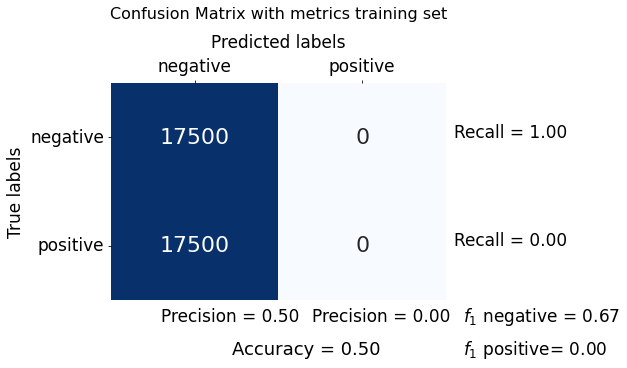

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


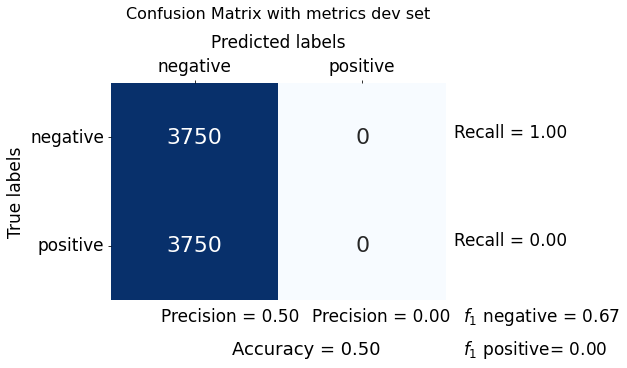

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


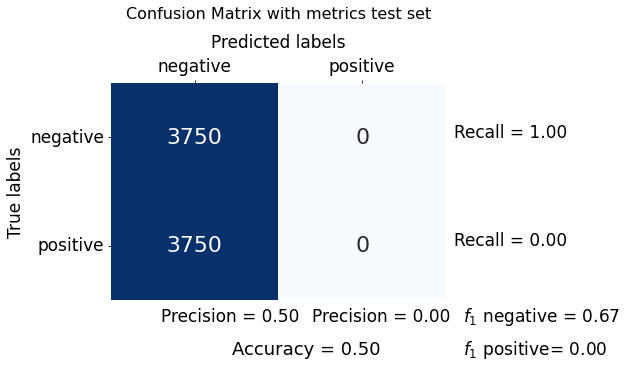

In [ ]:
clf = DummyClassifier(strategy = 'most_frequent')

y_train_pred_dummy, y_dev_pred_dummy, y_test_pred_dummy = classify(clf, vectorized_x_train, y_train, vectorized_x_dev, y_dev, vectorized_x_test, y_test)

* Naive Bayes with TFIDF

train precision score: 0.8931428571428571
Dev precision score: 0.8696
Test precision score: 0.8729333333333333

train recall score: 0.8931428571428571
Dev recall score: 0.8696
Test recall score: 0.8729333333333333

train f1-score: 0.8931428571428571
Dev f1-score: 0.8695999999999999
Test f1-score: 0.8729333333333333





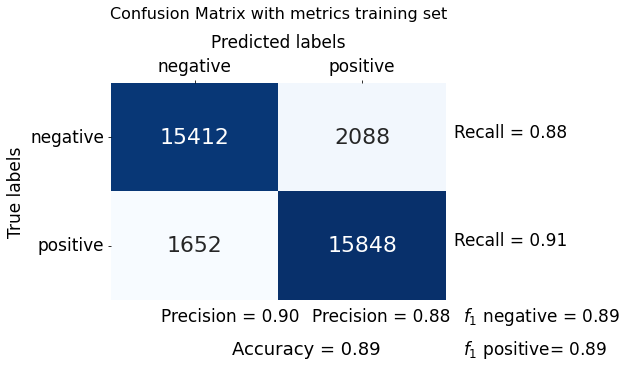

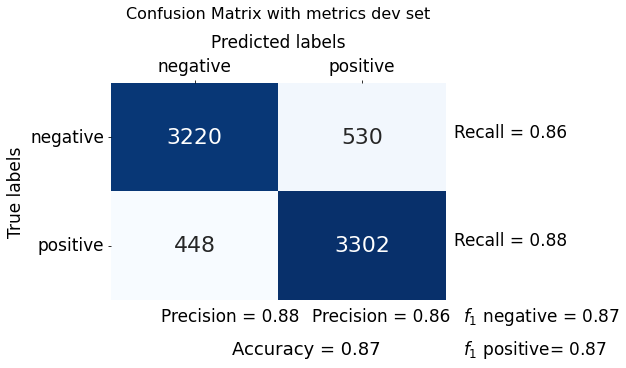

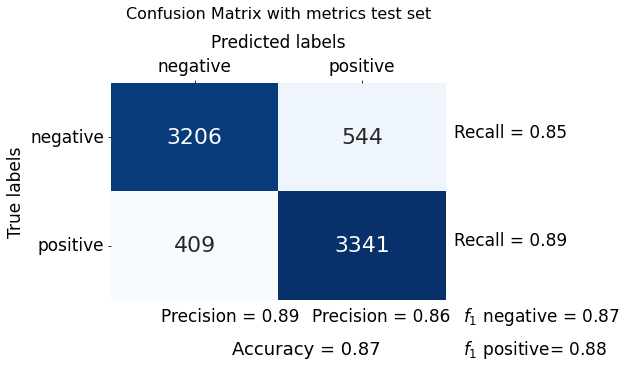

In [ ]:
clf = MultinomialNB()

y_train_pred_nb, y_dev_pred_nb, y_test_pred_nb = classify(clf, vectorized_x_train, y_train, vectorized_x_dev, y_dev, vectorized_x_test, y_test)

* Logistic Regression with TFIDF

train precision score: 0.9350285714285714
Dev precision score: 0.8941333333333333
Test precision score: 0.9001333333333333

train recall score: 0.9350285714285714
Dev recall score: 0.8941333333333333
Test recall score: 0.9001333333333333

train f1-score: 0.9350285714285714
Dev f1-score: 0.8941333333333334
Test f1-score: 0.9001333333333333





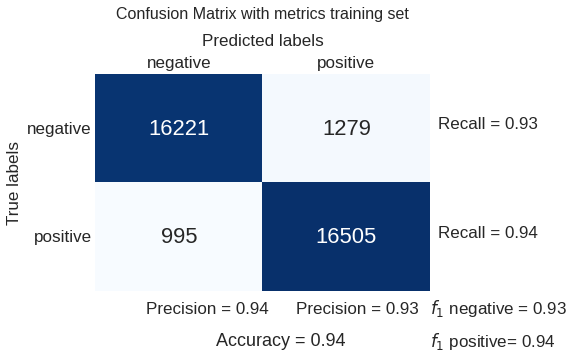

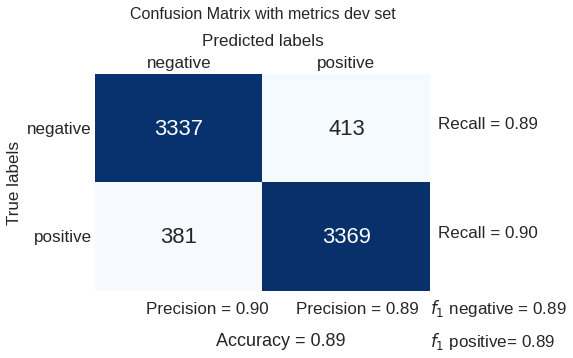

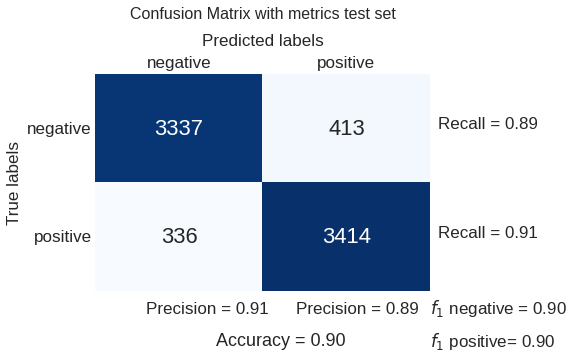

In [ ]:
clf = LogisticRegression(solver = "liblinear")

y_train_pred_lr, y_dev_pred_lr, y_test_pred_lr = classify(clf, vectorized_x_train, y_train, vectorized_x_dev, y_dev, vectorized_x_test, y_test)

* SVM without Dim Reduction TFIDF - Time Consuming - Needs to run sometime in the future to take results.

In [ ]:
# from sklearn import svm

clf = svm.SVC(kernel = 'rbf')

classify(clf, vectorized_x_train, y_train, vectorized_x_dev, y_dev, vectorized_x_test, y_test)

* SVM with Dim Reduction TFIDF

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


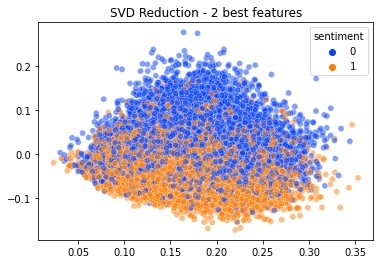

In [ ]:
# Dimensionality Reduction using SVD
svd = TruncatedSVD(n_components=2, random_state=1994)
palette = sns.color_palette("bright", 2)

x_train_trunc = svd.fit_transform(vectorized_x_train)

plt.figure()
plt.title('SVD Reduction - 2 best features')
sns.scatterplot(x_train_trunc[:,0], x_train_trunc[:,1], hue=y_train, legend='full', palette=palette, alpha=0.5)

train precision score: 0.894
Dev precision score: 0.8610666666666666
Test precision score: 0.8688

train recall score: 0.894
Dev recall score: 0.8610666666666666
Test recall score: 0.8688

train f1-score: 0.894
Dev f1-score: 0.8610666666666666
Test f1-score: 0.8688





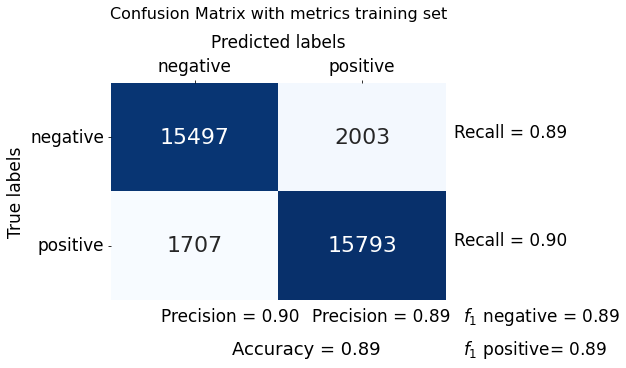

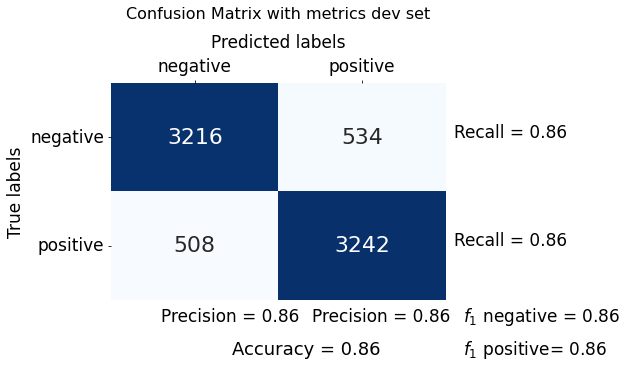

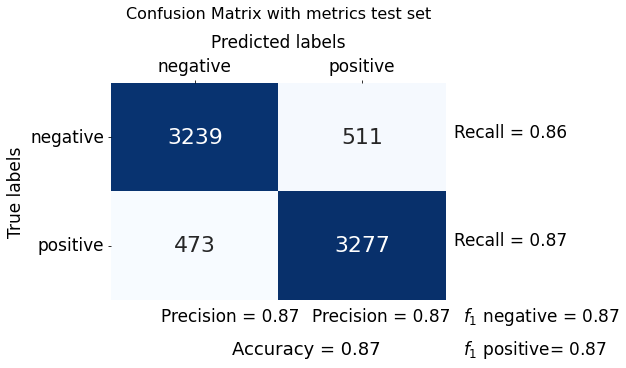

In [ ]:
svd = TruncatedSVD(n_components = 50, random_state = 1994)

# Create TF/IDF vectorized data sets.
vectorized_x_train_svd = svd.fit_transform(vectorized_x_train)
vectorized_x_dev_svd = svd.transform(vectorized_x_dev)
vectorized_x_test_svd = svd.transform(vectorized_x_test)

clf_svm = svm.SVC(kernel = 'rbf')

y_train_pred_svm, y_dev_pred_svm, y_test_pred_svm = classify(clf_svm, vectorized_x_train_svd, y_train, vectorized_x_dev_svd, y_dev, vectorized_x_test_svd, y_test)

* KNN with TFIDF

train precision score: 0.8742571428571428
Dev precision score: 0.7954666666666667
Test precision score: 0.7970666666666667

train recall score: 0.8742571428571428
Dev recall score: 0.7954666666666667
Test recall score: 0.7970666666666667

train f1-score: 0.8742571428571428
Dev f1-score: 0.7954666666666667
Test f1-score: 0.7970666666666667





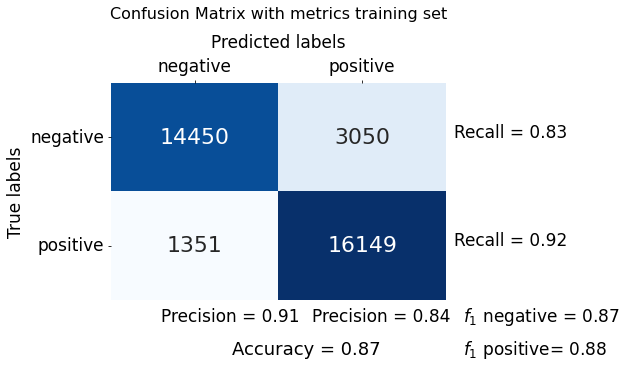

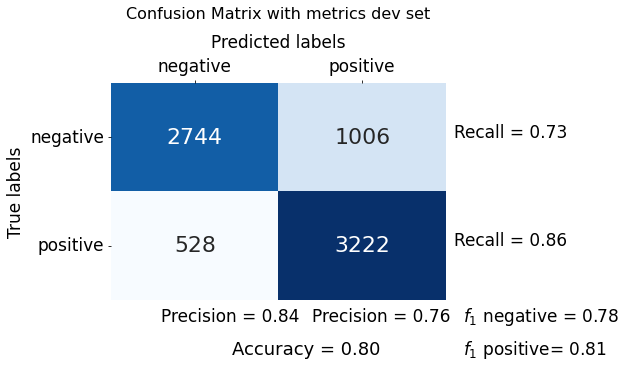

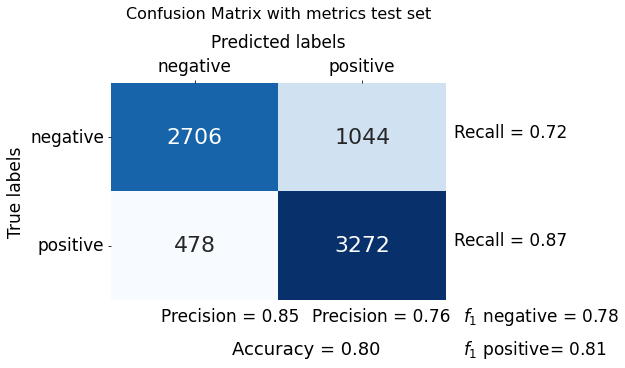

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 5)

y_train_pred_knn, y_dev_pred_knn, y_test_pred_knn = classify(clf, vectorized_x_train, y_train, vectorized_x_dev, y_dev, vectorized_x_test, y_test)

#### Optimization

GridSearch for Naive Bayes TFIDF

In [ ]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

parameters = {
    'vect__max_features': [5000, 15000],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': (1e-2, 1e-4, 1e-6)
}

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)

cv = StratifiedKFold(n_splits=2, random_state = 1994, shuffle = True)
# cv = ShuffleSplit(n_splits = 1, random_state=1994) # alternative method should obtain the same dev set with the beginning

grid_search = GridSearchCV(pipeline, parameters, cv = cv, n_jobs = -1, verbose = 1, error_score = 'raise')
#grid_search.fit(x_dev, y_dev) I CHANGED THIS, think Train data is the correct (Agis)
grid_search.fit(x_train_total, y_train_total)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

bestNaiveBayesEstimator = grid_search.best_estimator_

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_features': [5000, 15000], 'vect__ngram_range': [(1, 1), (1, 2)], 'clf__alpha': (0.01, 0.0001, 1e-06)}
Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best score: 0.871
Best parameters set:
	clf__alpha: 0.01
	vect__max_features: 15000
	vect__ngram_range: (1, 2)


In [ ]:
bestNaiveBayesEstimator.fit(x_train_total, y_train_total)
print(classification_report(y_train_total, bestNaiveBayesEstimator.predict(x_train_total)))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88     21250
           1       0.88      0.90      0.89     21250

    accuracy                           0.88     42500
   macro avg       0.88      0.88      0.88     42500
weighted avg       0.88      0.88      0.88     42500



Performing gridsearch with 50k reviews is time consuming. I have tried with the **first 10k to get a sense of the parameters** and I am keeping them here. **We have to RUN it on the full 50k review at some point.**

**Output:**

Fitting 5 folds for each of 45 candidates, totalling 225 fits

Best score: 0.872
Best parameters set:

	* clf__alpha: 0.001
	* vect__max_features: 25000
	* vect__ngram_range: (1, 2)

GridSearch for Logistic Regression TFIDF

In [ ]:
# pipeline = Pipeline([
#     ('vect', TfidfVectorizer()),
#     ('clf', LogisticRegression())
# ])

# parameters = {
#     'vect__max_features': [10000],
#     'vect__ngram_range': [(1, 2)],
#     'clf__solver': ['liblinear'],
#     'clf__C': [1, 10, 100, 1000]
# }

# print("Performing grid search...")
# print("pipeline:", [name for name, _ in pipeline.steps])
# print("parameters:")
# print(parameters)

# cv = StratifiedKFold(n_splits = 5, random_state = 1994, shuffle = True)

# grid_search = GridSearchCV(pipeline, parameters, cv = cv, n_jobs =-1, verbose = 1, error_score = 'raise')
# grid_search.fit(x_train_total, y_train_total)

# print("Best score: %0.3f" % grid_search.best_score_)
# print("Best parameters set:")
# best_parameters = grid_search.best_estimator_.get_params()
# for param_name in sorted(parameters.keys()):
#     print("\t%s: %r" % (param_name, best_parameters[param_name]))

# bestLogisticRgressionEstimator = grid_search.best_estimator_

Saving the trained model so that we don't have to train it again in every run. We can then load our pretrained model any time.

In [ ]:
import joblib

# Commenting out the dump function for now - uncomment if you wish to dump a new trained model

#joblib.dump(bestLogisticRgressionEstimator, 'log_reg_gridsearch.pkl')


#### Diagnose - Plot Learning Curves - TO BE DONE

In [ ]:
import os

os.listdir()


['.config',
 'adc.json',
 'imdb.csv',
 'log_reg_gridsearch.pkl',
 'drive',
 'sample_data']

In [ ]:
best_model = joblib.load('log_reg_gridsearch.pkl')

#### Validation on TEST set

Loading our pretrained model

In [ ]:
best_model = joblib.load('/content/log_reg_gridsearch.pkl')

y_pred = best_model.predict(x_test)
score = f1_score(y_test, y_pred, average = 'micro')
print("test f1-score:", score)
print()

y_true = pd.Series(y_test, name = 'True')
y_pred = pd.Series(y_pred, name = 'Predicted')
display(pd.crosstab(y_true, y_pred))

test f1-score: 0.9017333333333334



Predicted,0,1
True,,
0,3356,394
1,343,3407


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      3750
           1       0.90      0.91      0.90      3750

    accuracy                           0.90      7500
   macro avg       0.90      0.90      0.90      7500
weighted avg       0.90      0.90      0.90      7500



In [ ]:
best_model.named_steps

{'clf': LogisticRegression(C=1, solver='liblinear'),
 'vect': TfidfVectorizer(max_features=10000, ngram_range=(1, 2))}

ROC CURVES

In [ ]:
clf_dummy = DummyClassifier(strategy = 'most_frequent').fit(vectorized_x_train, y_train)
clf_nb = MultinomialNB().fit(vectorized_x_train, y_train)
clf_lr = LogisticRegression(solver = "liblinear").fit(vectorized_x_train, y_train)
clf_svm = svm.SVC(kernel = 'rbf').fit(vectorized_x_train_svd, y_train)
clf_knn = KNeighborsClassifier(n_neighbors = 5).fit(vectorized_x_train, y_train)


In [ ]:
# classifiers = {"SVM": clf}
# subsets = {'Train': [vectorized_x_train_svd, y_train],
#            'Development': [vectorized_x_dev_svd, y_dev],
#            'Test': [vectorized_x_test_svd, y_test]}
classifiers = {
                "Dummy Classifier": clf_dummy,
                "Naive Bayes": clf_nb,
                "Logistic Regression": clf_lr,
                 "kNN": clf_knn
               }

subsets = {'Train': [vectorized_x_train, y_train],
           'Development': [vectorized_x_dev, y_dev],
           'Test': [vectorized_x_test, y_test]}


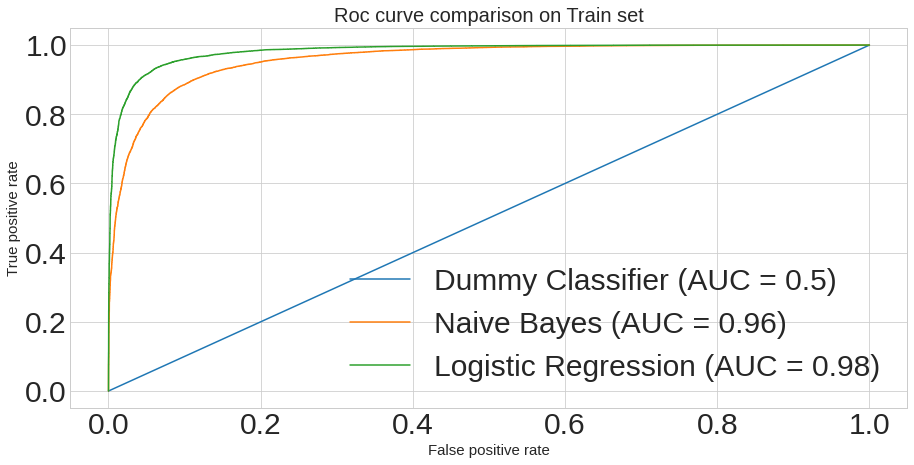

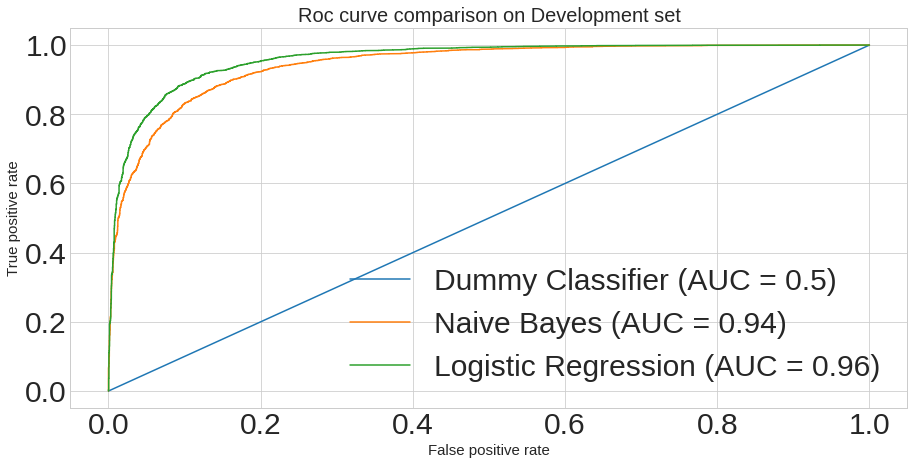

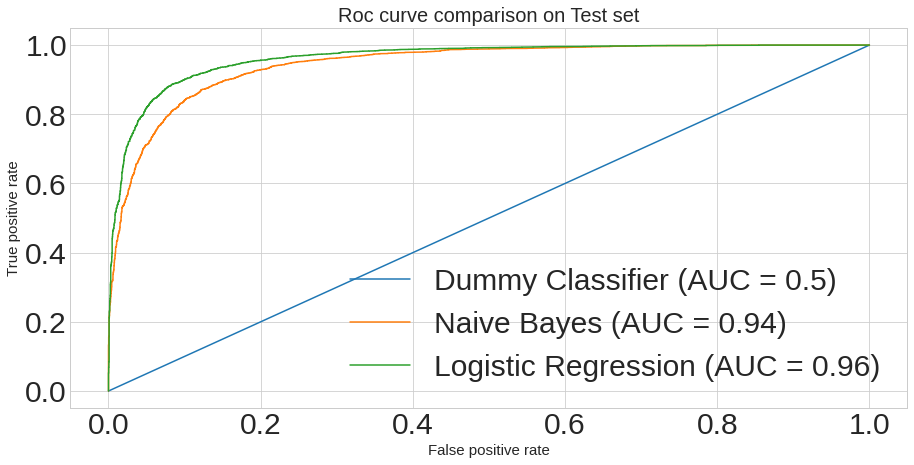

In [ ]:
for subset_name, subset_list in subsets.items():

    plt.figure(figsize=(15,7))
    plt.style.use('seaborn-whitegrid')

    for name_clf, clf in list(classifiers.items())[:-1]:

        fpr, tpr, threshlods = roc_curve(subset_list[1], clf.predict_proba(subset_list[0])[:,1])
        area = auc(fpr,tpr)
        plt.plot(fpr, tpr, label=name_clf + ' (AUC = ' + str(round(area,2))+')')

    plt.title("Roc curve comparison on " + subset_name + " set", fontsize=20)
    plt.xlabel("False positive rate", fontsize=15)
    plt.ylabel("True positive rate", fontsize=15)
    plt.legend()
    plt.style.use('seaborn-whitegrid')
    plt.show()
    print()

### Precision Recall Curves for positive class

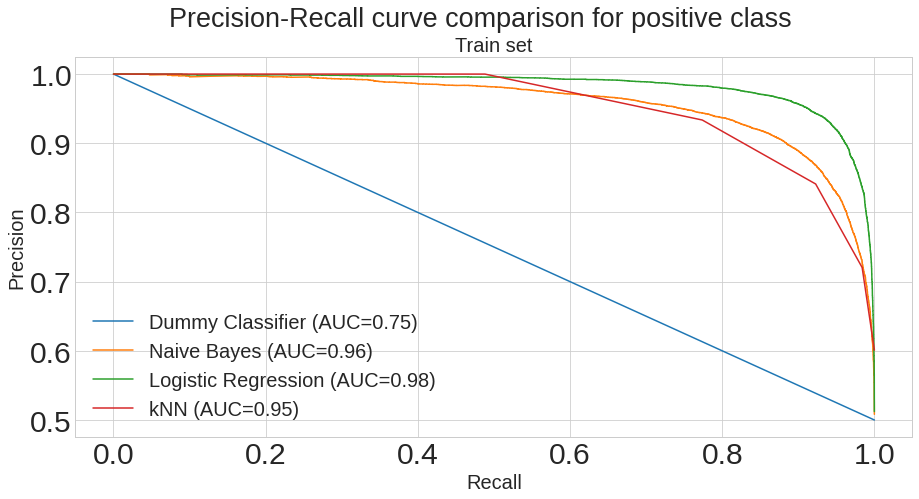

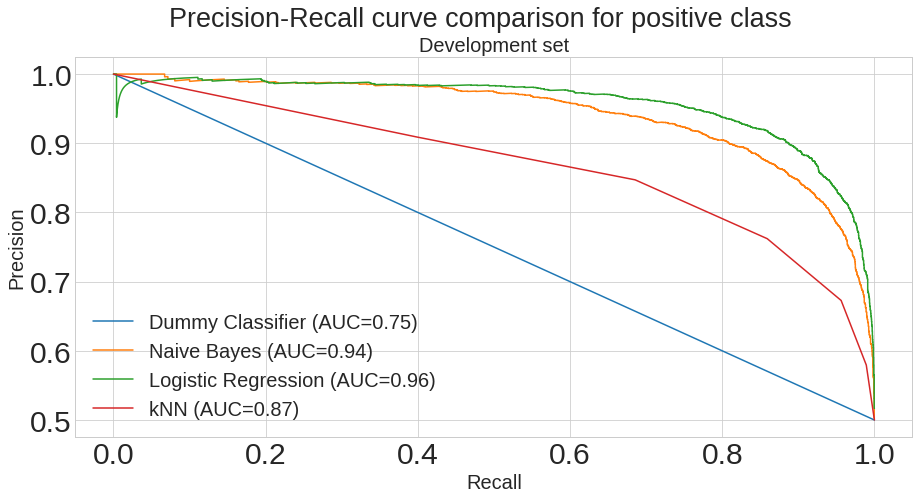

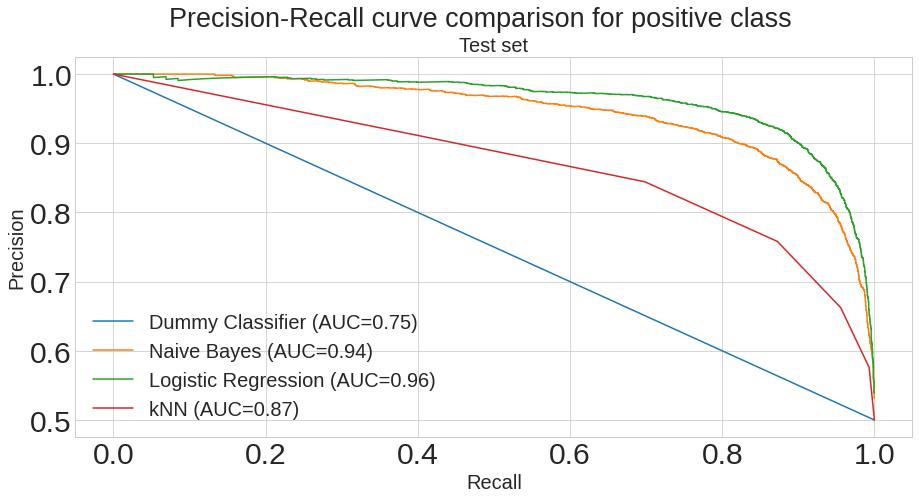

In [ ]:
for subset_name, subset_list in subsets.items():

    plt.figure(figsize=(15,7))

    for name_clf, clf in list(classifiers.items())[:4]:

        pr1, rec1, threshlods = precision_recall_curve(subset_list[1], clf.predict_proba(subset_list[0])[:,1])
        area = auc(rec1,pr1)
        plt.plot(rec1, pr1, label=name_clf + ' (AUC=' + str(round(area,2))+ ')')

    plt.title(subset_name + " set", fontsize=20)
    plt.suptitle("Precision-Recall curve comparison for positive class", fontsize=27)
    plt.xlabel("Recall", fontsize=20)
    plt.ylabel("Precision", fontsize=20)
    plt.legend(loc="lower left", fontsize=20)

    plt.show()
    print()

### Precision recall curve for negative class

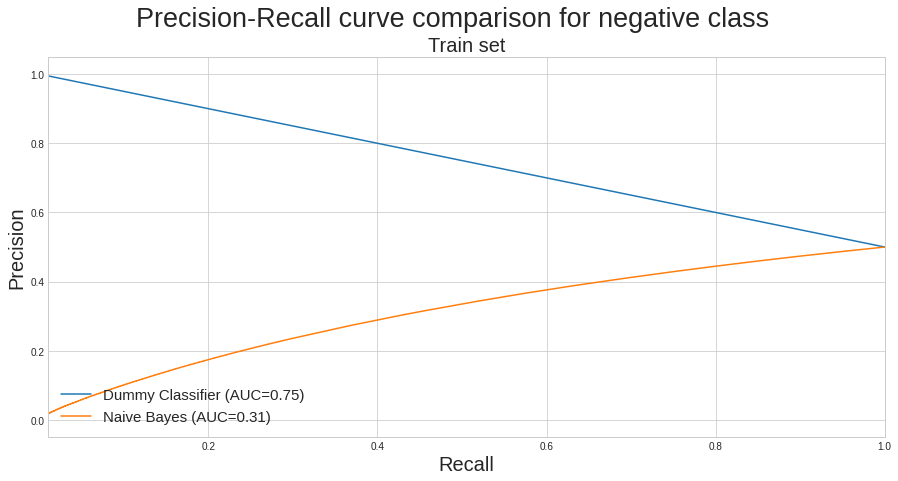

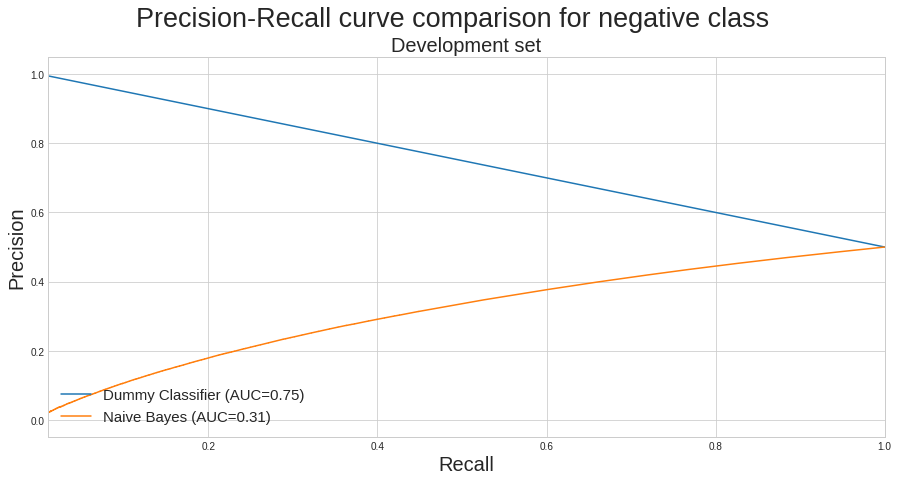

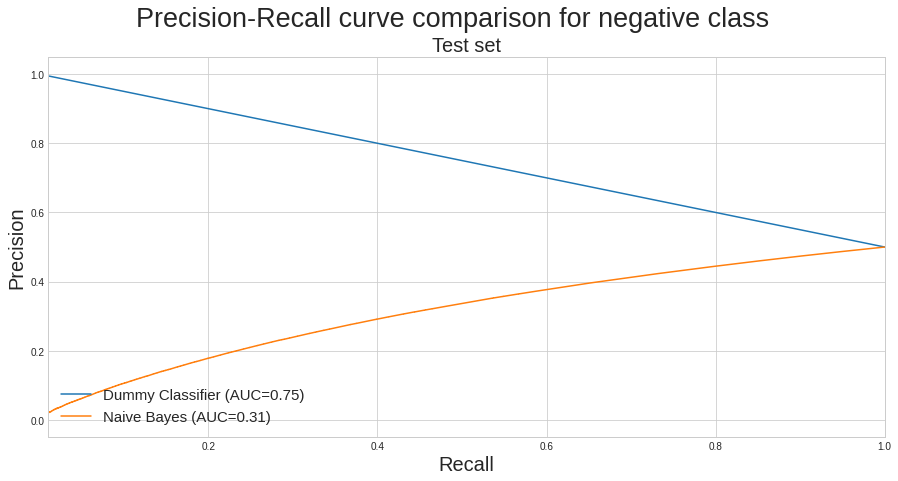

In [ ]:
for subset_name, subset_list in subsets.items():

    plt.figure(figsize=(15,7))

    for name_clf, clf in list(classifiers.items())[:-1]:

        pr0, rec0, threshlods = precision_recall_curve(subset_list[1], clf.predict_proba(subset_list[0])[:,0])
        area = auc(rec0,pr0)
        plt.plot(rec0, pr0, label=name_clf + ' (AUC=' + str(round(area,2))+ ')')

    plt.title(subset_name + " set", fontsize=20)
    plt.suptitle("Precision-Recall curve comparison for negative class", fontsize=27)
    plt.xlabel("Recall", fontsize=20)
    plt.ylabel("Precision", fontsize=20)
    plt.legend(loc="lower left", fontsize=15)
    plt.xlim(0.01,1)
    plt.show()
    print()

### Learning Curve-SVM(with dim reduction)

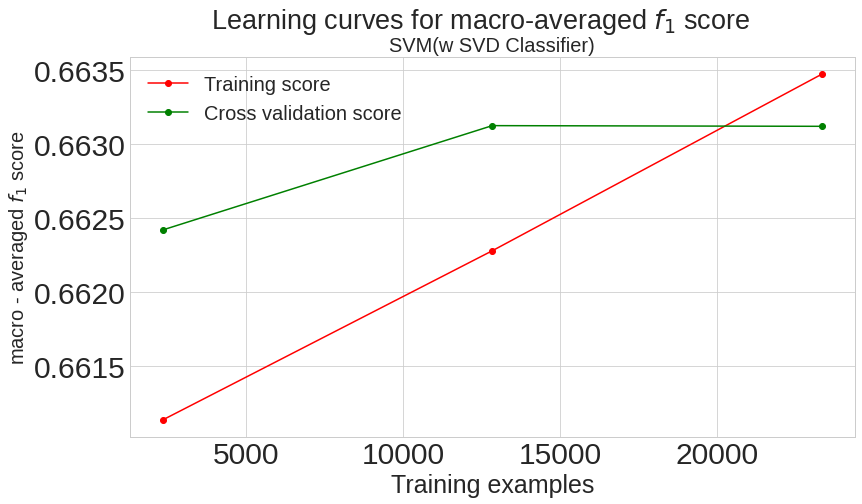

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
        clf_svm,
        vectorized_x_train_svd,
        y_train,
        cv=3,
        train_sizes=np.linspace(0.1, 1.0, 3),
        scoring='f1_macro'
    )

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(13,7))

plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross validation score")

plt.title('SVM(w SVD Classifier)', fontsize=20)
plt.suptitle("Learning curves for macro-averaged $f_1$ score", fontsize=27)
plt.xlabel("Training examples", fontsize=25)
plt.ylabel("macro - averaged $f_1$ score", fontsize=20)
plt.legend(fontsize=20)
plt.style.use('seaborn-whitegrid')

plt.show()
print()

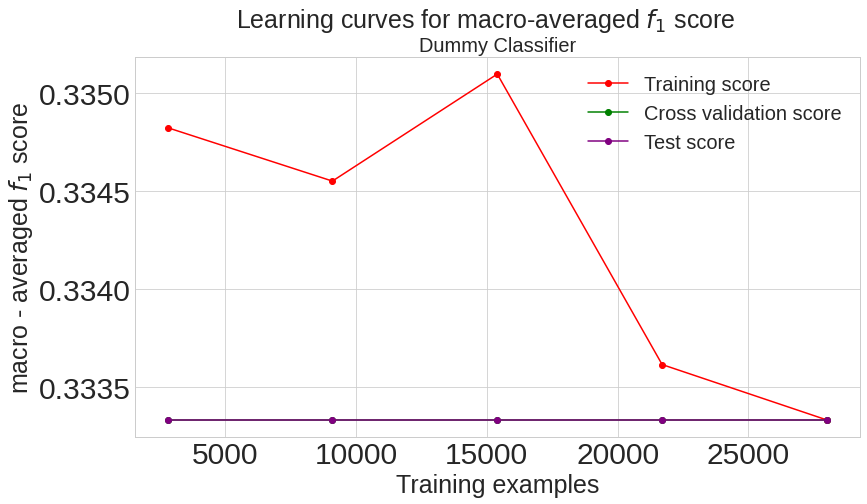

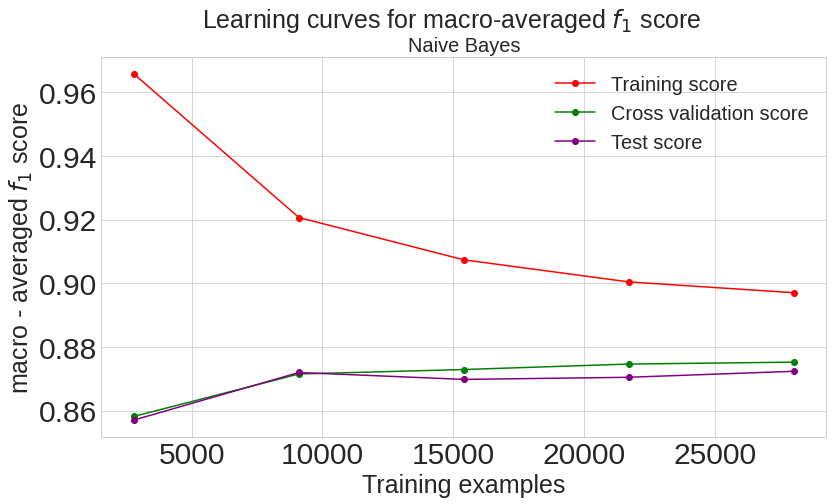

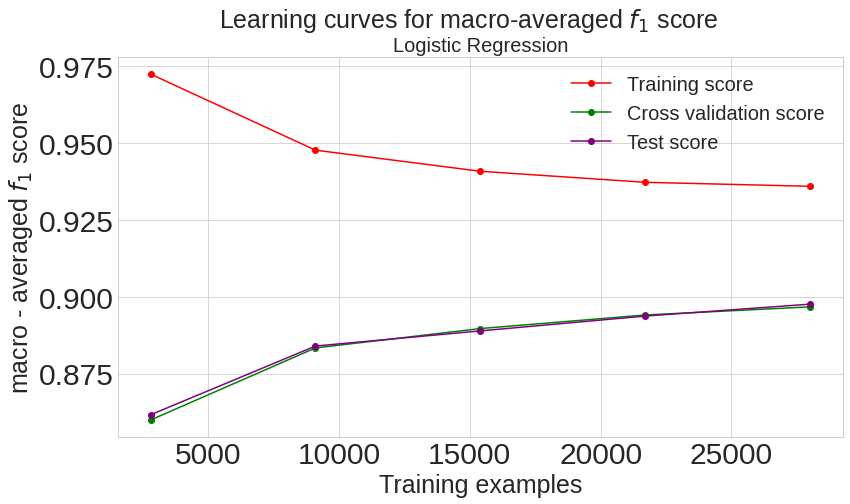

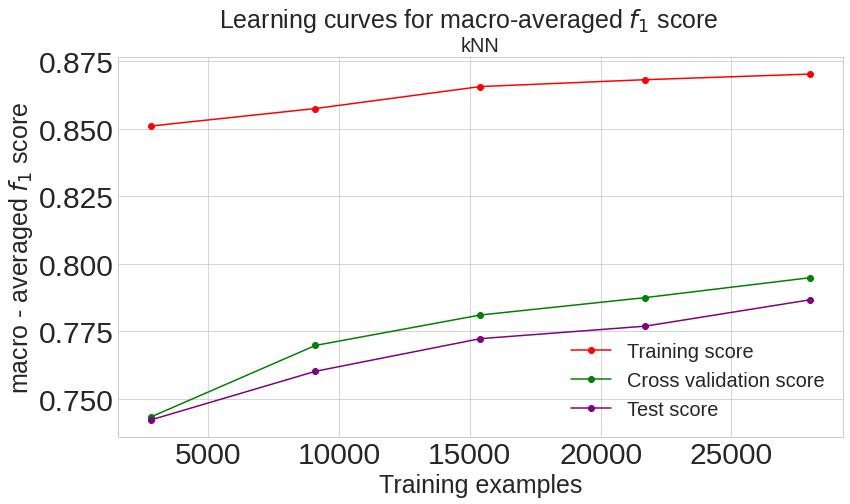

In [ ]:
for name_clf, clf in list(classifiers.items())[:]:
    train_sizes, train_scores, test_scores = learning_curve(
        clf,
        vectorized_x_train,
        y_train,
        cv=5,
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring='f1_macro'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(13,7))
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross validation score")

    #plot test curve as well
    glist=[]
    for i in range(len(list(train_sizes))):
      tr = list(train_sizes)[i]
      # fit the model
      clf.fit(vectorized_x_train.toarray()[:tr], y_train[:tr])
      # test prediction
      y = clf.predict(vectorized_x_test)
      #y = np.mean(y, axis=1)
      g = f1_score(y_test, y, average='macro')
      glist.append(g)
    plt.plot(list(train_sizes),glist, "o-", color="purple", label="Test score")


    plt.title(name_clf, fontsize=20)
    plt.suptitle("Learning curves for macro-averaged $f_1$ score", fontsize=25)
    plt.xlabel("Training examples", fontsize=25)
    plt.ylabel("macro - averaged $f_1$ score", fontsize=25)
    plt.legend(fontsize=20)
    plt.style.use('seaborn-whitegrid')

    plt.show()
    print()